In [1]:
import plotly
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")


In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [5]:
strategy_name = 'EntropySampling'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 50,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 2, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True},
             'loader_te_args': {'batch_size': 2, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:09,  1.77it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [12]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [13]:
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [14]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)

In [15]:
# initial round of training, round 0
dataset.initialize_labels(NUM_INIT_LB)

In [16]:
ids,_ = dataset.get_labeled_data()

selected_inds = {}
selected_inds[0] = ids

if not os.path.exists(log_folder_root + 'rns_active_selected/' + strategy_name):
    os.makedirs(log_folder_root + 'rns_active_selected/' + strategy_name)

# Serialize and save to a file
with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    pickle.dump(selected_inds, f)

In [17]:
strategy.train()

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [35]:
for rd in range(1, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd - 1) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd - 1) + '-epoch=' + str(int(max_row['epoch'])).zfill(2)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    q_idxs = strategy.query(NUM_QUERY * 90)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    selected_inds[rd] = q_idxs
    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
        pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    strategy.net.round = rd
    strategy.net.net.load_state_dict(modelstate)
    strategy.train()
    break

round 1
15 EntropySampling_round_0-epoch=29-train_loss=0.01449-v1.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

total_select_from 3713.0
selected 1730.0


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [38]:
torch.log(probs)

tensor([[-1.0848e-05, -1.1437e+01],
        [-3.2187e-06, -1.2649e+01],
        [-2.7418e-06, -1.2813e+01],
        ...,
        [-1.5497e-06, -1.3345e+01],
        [-1.9074e-06, -1.3191e+01],
        [-1.0729e-05, -1.1445e+01]])

In [18]:


probs, seq_len = strategy.predict_prob(unlabeled_data)

NameError: name 'unlabeled_data' is not defined

In [18]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_train_data_unaugmented()

In [165]:
probs, seq_len = strategy.predict_prob_dropout_split(unlabeled_data, n_drop=5)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [60]:
probs[0][0]

tensor([0.9831, 0.0169])

In [61]:
probs[1][0]

tensor([0.9788, 0.0212])

In [62]:
probs[2][0]

tensor([9.9986e-01, 1.3955e-04])

In [23]:
embeddings

array([[-0.7578125 ,  0.73876953, -0.7607422 , ..., -1.        ,
         1.        , -0.98291016],
       [-0.9638672 ,  0.9589844 , -0.9638672 , ..., -1.        ,
         1.        , -0.97753906],
       [-0.99365234,  0.9941406 , -0.9946289 , ..., -1.        ,
         1.        , -0.9506836 ],
       ...,
       [-0.99902344,  1.        , -1.        , ..., -0.9946289 ,
         0.9946289 , -0.8833008 ],
       [-1.        ,  1.        , -1.        , ..., -0.9628906 ,
         0.9638672 , -0.80810547],
       [-1.        ,  1.        , -1.        , ..., -0.7578125 ,
         0.76171875, -0.5185547 ]], dtype=float32)

In [21]:
cluster_learner = KMeans(n_clusters=170)
cluster_learner.fit(embeddings)

cluster_idxs = cluster_learner.predict(embeddings)
centers = cluster_learner.cluster_centers_[cluster_idxs]
dis = (embeddings - centers)**2
dis = dis.sum(axis=1)

KeyboardInterrupt: 

In [18]:
import copy
labeled_idxs, train_data = strategy.dataset.get_train_data_unaugmented()


#
# dist_mat = np.matmul(embeddings, embeddings.transpose())
# sq = np.array(dist_mat.diagonal()).reshape(len(labeled_idxs), 1)
# dist_mat *= -2
# dist_mat += sq
# dist_mat += sq.transpose()
# dist_mat = np.sqrt(dist_mat)
#
# mat = dist_mat[~labeled_idxs, :][:, labeled_idxs]
#
# mat_copy = copy.deepcopy(mat)



# output = np.arange(strategy.dataset.n_pool)[(strategy.dataset.labeled_idxs ^ labeled_idxs)]

In [19]:
embeddings, seq_len  = strategy.get_grad_embeddings(train_data)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

In [31]:
predictions = strategy.net.run_prediction(train_data)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

NameError: name 'nn' is not defined

In [32]:
output_list = []
emb_list = []
seq_len_list = []
m = torch.nn.Softmax(dim=1)
for pred, y, emb, emb_t, seq_len in predictions:
    output_list.append(pred)
    emb_list.append(emb_t)
    seq_len_list.append(seq_len)
emb = torch.vstack(emb_list)
out = emb.data.cpu().numpy()
pred_raw = torch.vstack(output_list)
batchProbs = m(pred_raw.float()).data.cpu().numpy()
maxInds = np.argmax(batchProbs, 1)

nLab = batchProbs.shape[1]
embDim = emb.shape[1]
embeddings = np.zeros([len(emb), embDim * nLab])

for j in range(len(emb)):
    for c in range(nLab):
        if c == maxInds[j]:
            embeddings[j][embDim * c: embDim * (c + 1)] = deepcopy(out[j]) * (
                    1 - batchProbs[j][c]) * -1.0
        else:
            embeddings[j][embDim * c: embDim * (c + 1)] = deepcopy(out[j]) * (
                    -1 * batchProbs[j][c]) * -1.0

In [33]:
embeddings

array([[ 0.        , -0.00065136,  0.00064993, ..., -0.00085592,
         0.00085592, -0.00085592],
       [ 0.        , -0.0003612 ,  0.00036097, ..., -0.00037479,
         0.00037479, -0.00037479],
       [ 0.        , -0.00032783,  0.00032759, ..., -0.00032949,
         0.00032949, -0.00032949],
       ...,
       [ 0.        , -0.00033092,  0.00033092, ..., -0.00032902,
         0.00032902, -0.00032902],
       [ 0.        , -0.00037408,  0.00037408, ..., -0.00036049,
         0.00036049, -0.00036049],
       [ 0.        , -0.00085735,  0.00085735, ..., -0.00065279,
         0.00065327, -0.00065231]])

In [34]:
from sklearn.metrics import pairwise_distances
from scipy import stats
# import pdb
def init_centers(X, K):
    ind = np.argmax([np.linalg.norm(s, 2) for s in X])
    mu = [X[ind]]
    indsAll = [ind]
    centInds = [0.] * len(X)
    cent = 0
    print('#Samps\tTotal Distance')
    while len(mu) < K:
        if len(mu) == 1:
            D2 = pairwise_distances(X, mu).ravel().astype(float)
        else:
            newD = pairwise_distances(X, [mu[-1]]).ravel().astype(float)
            for i in range(len(X)):
                if D2[i] >  newD[i]:
                    centInds[i] = cent
                    D2[i] = newD[i]
        print(str(len(mu)) + '\t' + str(sum(D2)), flush=True)
        if sum(D2) == 0.0: return indsAll
        D2 = D2.ravel().astype(float)
        Ddist = (D2 ** 2)/ sum(D2 ** 2)
        customDist = stats.rv_discrete(name='custm', values=(np.arange(len(D2)), Ddist))
        ind = customDist.rvs(size=1)[0]
        while ind in indsAll: ind = customDist.rvs(size=1)[0]
        mu.append(X[ind])
        indsAll.append(ind)
        cent += 1
    return indsAll

In [38]:
import time
start_time = time.time()
chosen = init_centers(embeddings, 6000)
print("--- %s seconds ---" % (time.time() - start_time))

#Samps	Total Distance
1	1050462.6856461521
2	13398.823531457
3	12039.864059283313
4	11608.163516110984
5	11294.450325505564
6	11016.375126331506
7	10549.2087688005
8	10092.157135533036
9	9708.546623633762
10	9645.610267379234
11	9331.60583446261
12	9032.262037556324
13	9003.766055025191
14	8862.794998889553
15	8756.554505156977
16	8645.371615559048
17	8513.863301195852
18	8487.508694089705
19	8427.230222365228
20	8425.045629318283
21	8374.104934894645
22	8326.754405858866
23	8310.517386794938
24	8276.608807195613
25	8119.40570806348
26	8010.895922306048
27	7821.683277282652
28	7818.190057171224
29	7619.647439587262
30	7606.048308655882
31	7593.1543383149055
32	7590.536222200852
33	7506.279937684281
34	7443.6352234519845
35	7429.667880603441
36	7373.392323927407
37	7275.70801122265
38	7251.444348822994
39	7228.849166530103
40	7217.351657165223
41	7212.294433590259
42	7202.5124821741865
43	7121.223946740327
44	6978.673857693407
45	6973.627440815069
46	6939.07538046762
47	6925.40260336823

In [40]:
strategy.keep_continuous_segments(np.sort(chosen),10)

array([  543,   544,   545, ..., 84639, 84640, 84641], dtype=int64)

In [367]:
norm_data = embeddings_t / np.linalg.norm(embeddings_t, axis=1, keepdims=True)

dist_mat = np.dot(norm_data, norm_data.T)

In [418]:

mat = dist_mat[~labeled_idxs, :][:, labeled_idxs]

mat_copy = copy.deepcopy(mat)
for i in tqdm(range(3000), ncols=100):
    mat_min = mat.min(axis=1)
    q_idx_ = np.argmax(mat_min)
    q_idx = np.arange(strategy.dataset.n_pool)[~labeled_idxs][q_idx_]
    labeled_idxs[q_idx] = True
    mat = np.delete(mat, q_idx_, 0)
    mat = np.append(mat, dist_mat[~labeled_idxs,q_idx][:, None], axis=1)

100%|███████████████████████████████████████████████████████████| 3000/3000 [20:50<00:00,  2.40it/s]


In [379]:
mat.shape

(84331, 779)

In [405]:
labeled_idxs

array([False, False, False, ..., False, False, False])

In [402]:
print(dist_mat[~labeled_idxs][:,q_idx].shape)

(84322, 10)


In [396]:
mat_ind = np.zeros_like(labeled_idxs)
mat_ind[q_idx] = True

In [398]:
mat_ind

array([False, False, False, ..., False, False, False])

In [386]:
~labeled_idxs

array([ True,  True,  True, ...,  True,  True,  True])

In [232]:
embeddings = embeddings_t.numpy()
#
# dist_mat = np.matmul(embeddings, embeddings.transpose())
# sq = np.array(dist_mat.diagonal()).reshape(len(labeled_idxs), 1)
# dist_mat *= -2
# dist_mat += sq
# dist_mat += sq.transpose()
# dist_mat = np.sqrt(dist_mat)
#
# mat = dist_mat[~labeled_idxs, :][:, labeled_idxs]
#
# mat_copy = copy.deepcopy(mat)

norm_data = embeddings_t / np.linalg.norm(embeddings_t, axis=1, keepdims=True)

similarity_matrix = np.dot(norm_data, norm_data.T)

In [242]:
similarity_matrix[0]

array([0.9999998 , 0.9927871 , 0.9901861 , ..., 0.98667955, 0.9866349 ,
       0.96265787], dtype=float32)

In [244]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
test = cos(embeddings_t,embeddings_t[0])

In [245]:
np.array_equal(similarity_matrix[0], test.numpy())

False

In [249]:
np.mean(similarity_matrix[0]-test.numpy())

-6.30782e-09

In [419]:
output = np.arange(strategy.dataset.n_pool)[(strategy.dataset.labeled_idxs ^ labeled_idxs)]

In [449]:
output

array([  143,   266,   267, ..., 84722, 84723, 84724])

In [437]:
changed_ind = np.where(np.sign(np.diff(output)-1)==1)[0]
changed_ind

array([   0,    4,   10,   21,   33,   43,   44,   47,   54,   60,   76,
         83,   84,   97,  101,  111,  115,  116,  119,  126,  128,  130,
        137,  141,  142,  145,  158,  176,  179,  182,  183,  188,  198,
        200,  202,  214,  215,  216,  223,  234,  243,  244,  249,  251,
        253,  254,  259,  261,  269,  270,  274,  277,  282,  290,  297,
        305,  306,  309,  313,  317,  322,  326,  340,  348,  353,  359,
        361,  364,  371,  382,  391,  393,  394,  404,  412,  417,  423,
        433,  437,  444,  445,  447,  455,  457,  473,  477,  478,  479,
        485,  494,  495,  498,  509,  512,  513,  516,  517,  521,  522,
        523,  531,  532,  535,  536,  537,  538,  541,  545,  557,  559,
        562,  563,  574,  577,  585,  586,  590,  595,  609,  610,  614,
        616,  618,  621,  622,  623,  635,  641,  649,  650,  655,  663,
        664,  687,  690,  694,  698,  699,  702,  706,  708,  714,  717,
        724,  728,  733,  734,  739,  744,  750,  7

In [457]:
l = 0
for i in range(len(greater_than_10)):
    l+= len(output[changed_ind[greater_than_10][i]+1:changed_ind[greater_than_10+1][i]+1])
l

1345

In [446]:
changed_ind[greater_than_10],changed_ind[greater_than_10+1]

(array([  10,   21,   60,   84,  145,  158,  202,  223,  326,  371,  457,
         498,  545,  563,  595,  623,  664,  759,  823,  901,  930, 1004,
        1016, 1045, 1061, 1089, 1105, 1126, 1147, 1199, 1244, 1317, 1422,
        1506, 1562, 1636, 1702, 1740, 1767, 1799, 1818, 1829, 1859, 2051,
        2091, 2108, 2137, 2154, 2182, 2204, 2229, 2248, 2301, 2314, 2376,
        2407, 2471, 2505, 2548, 2562, 2586, 2638, 2655, 2685, 2703, 2725,
        2752, 2812, 2877, 2898, 2959], dtype=int64),
 array([  21,   33,   76,   97,  158,  176,  214,  234,  340,  382,  473,
         509,  557,  574,  609,  635,  687,  771,  834,  925,  945, 1015,
        1036, 1058, 1074, 1105, 1116, 1146, 1160, 1210, 1262, 1332, 1433,
        1537, 1582, 1651, 1714, 1756, 1782, 1810, 1829, 1841, 1871, 2062,
        2104, 2125, 2154, 2167, 2194, 2222, 2241, 2261, 2314, 2327, 2389,
        2433, 2489, 2532, 2562, 2575, 2613, 2649, 2667, 2697, 2715, 2739,
        2766, 2823, 2889, 2912, 2970], dtype=int64))

In [454]:
greater_than_10 = np.where(np.diff(changed_ind)>8)[0]

In [455]:
np.diff(changed_ind)

array([ 4,  6, 11, 12, 10,  1,  3,  7,  6, 16,  7,  1, 13,  4, 10,  4,  1,
        3,  7,  2,  2,  7,  4,  1,  3, 13, 18,  3,  3,  1,  5, 10,  2,  2,
       12,  1,  1,  7, 11,  9,  1,  5,  2,  2,  1,  5,  2,  8,  1,  4,  3,
        5,  8,  7,  8,  1,  3,  4,  4,  5,  4, 14,  8,  5,  6,  2,  3,  7,
       11,  9,  2,  1, 10,  8,  5,  6, 10,  4,  7,  1,  2,  8,  2, 16,  4,
        1,  1,  6,  9,  1,  3, 11,  3,  1,  3,  1,  4,  1,  1,  8,  1,  3,
        1,  1,  1,  3,  4, 12,  2,  3,  1, 11,  3,  8,  1,  4,  5, 14,  1,
        4,  2,  2,  3,  1,  1, 12,  6,  8,  1,  5,  8,  1, 23,  3,  4,  4,
        1,  3,  4,  2,  6,  3,  7,  4,  5,  1,  5,  5,  6,  5,  4, 12,  2,
        4,  1,  4,  3,  4,  6,  1,  1,  6,  6,  6,  4,  1,  1,  1,  1, 11,
        1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,
        1,  2,  1,  6,  1,  2,  1,  2,  1,  1,  1,  5,  7,  1,  5,  9, 24,
        5, 15,  6,  2,  3,  7,  5,  8,  6,  9,  1,  3,  2,  4,  3, 11,  1,
       20,  9, 13,  3, 13

In [443]:
len(greater_than_10)

71

In [468]:
def keep_continuous_segments(arr, n):
    changed_ind = np.where(np.sign(np.diff(arr)-1)==1)[0]
    valid_split = np.where(np.diff(changed_ind)>=n)[0]
    start_ind = changed_ind[valid_split]+1
    end_ind = changed_ind[valid_split+1]+1
    cleaned_arr = np.empty(0,dtype=int)
    for i in range(len(valid_split)):
        cleaned_arr = np.hstack((cleaned_arr,output[start_ind[i]:end_ind[i]]))
    return cleaned_arr

In [469]:
np.diff(keep_continuous_segments(output,8))

array([1, 1, 1, ..., 1, 1, 1])

In [127]:
from torch_kmeans import KMeans
n = 1700
labeled_idxs, train_data = strategy.dataset.get_train_data_unaugmented()
embeddings, embeddings_t, seq_len  = strategy.get_embeddings(train_data)
# embeddings = embeddings_t.numpy()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

In [203]:
from fast_pytorch_kmeans import KMeans
import time
start_time = time.time()

cluster_learner = KMeans(n_clusters=100, mode = 'cosine', verbose=1)
cluster_learner.fit(embeddings)
print("--- %s seconds ---" % (time.time() - start_time))

used 100 iterations (56.193s) to cluster 85111 items into 100 clusters
--- 56.19699692726135 seconds ---


In [471]:
cluster_idxs = cluster_learner.predict(embeddings)
centers = cluster_learner.centroids[cluster_idxs]
dis = (embeddings - centers) ** 2
dis = dis.sum(axis=1)

AssertionError: input must be torch.Tensor

In [472]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
embeddings, embeddings_t, seq_len = strategy.get_embeddings(unlabeled_data)





LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

AssertionError: input must be torch.Tensor

In [475]:
cluster_idxs = cluster_learner.predict(embeddings_t)
centers = cluster_learner.centroids[cluster_idxs]
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
dis = cos(embeddings_t, centers)
uncertainties = dis

In [474]:
start_time = time.time()
cluster_learner = KMeans(n_clusters=500, mode='cosine', verbose=1)
cluster_learner.fit(embeddings_t)
print("--- %s seconds ---" % (time.time() - start_time))

used 100 iterations (53.4011s) to cluster 85111 items into 500 clusters
--- 53.42008018493652 seconds ---


In [218]:
dis.shape

torch.Size([85111])

In [51]:
dist_mat[~labeled_idxs, q_idx][:, None]

array([[10.813714],
       [13.207396],
       [13.567594],
       ...,
       [13.984654],
       [14.197285],
       [14.527615]], dtype=float32)

In [47]:
labeled_idxs[q_idx]

True

In [48]:
q_idx

16183

In [50]:
mat.min(axis=1)

array([0.11158482, 0.14416127, 0.17985725, ..., 0.31575453, 0.35591918,
       0.2078771 ], dtype=float32)

In [40]:
mat = dist_mat[~unlabeled_idxs, :][:, unlabeled_idxs]

In [41]:
for i in tqdm(range(100), ncols=100):
    mat_min = mat.min(axis=1)
    print(mat.shape)
    q_idx_ = mat_min.argmax()
    q_idx = np.arange(strategy.dataset.n_pool)[~unlabeled_idxs][q_idx_]
    unlabeled_idxs[q_idx] = True
    mat = np.delete(mat, q_idx_, 0)
    print(mat.shape)
    break
    mat = np.append(mat, dist_mat[~labeled_idxs, q_idx][:, None], axis=1)


  0%|                                                                       | 0/100 [00:00<?, ?it/s]

(84328, 783)
(84327, 783)


In [65]:
cluster_learner = KMeans(n_clusters=n)
        cluster_learner.fit(embeddings)

        cluster_idxs = cluster_learner.predict(embeddings)
        centers = cluster_learner.cluster_centers_[cluster_idxs]
        dis = (embeddings - centers)**2
        dis = dis.sum(axis=1)
        q_idxs = np.array([np.arange(embeddings.shape[0])[cluster_idxs==i][dis[cluster_idxs==i].argmin()] for i in range(n)])

41.81666666666667

In [66]:
1700/60

28.333333333333332

In [194]:
np.concatenate(unlabeled_data.label)

array([0., 0., 0., ..., 0., 0., 0.])

In [476]:
n = 1700
# log_probs = torch.log(probs)
# uncertainties = probs.max(1)[0]
# uncertainties = (probs * log_probs).sum(1)
# probs_sorted, idxs = probs.sort(descending=True)
# uncertainties = probs_sorted[:, 0] - probs_sorted[:,1]
# sigma_c = np.std(probs.numpy(), axis=0)
# uncertainties = torch.from_numpy(np.mean(sigma_c, axis=-1))
# uncertainties = moving_average(uncertainties,10)
# uncertainties = dist_mat[:, output].min(1)
# uncertainties = dis
indices = np.argsort(uncertainties)
data_sorted = uncertainties[indices]
original_order = indices.argsort()
data_original = data_sorted[original_order]
cdf = np.arange(1, len(uncertainties) + 1) / len(uncertainties)
linear_data =np.interp(cdf, (cdf.min(), cdf.max()), (0, 1))**0.3



In [415]:

dist_mat[:, output].min(1)

array([0.19087557, 0.19593614, 0.19644639, ..., 0.20131002, 0.19845071,
       0.19081613], dtype=float32)

In [309]:
uncertainties.sort(descending=True)[0]

TypeError: sort() got an unexpected keyword argument 'descending'

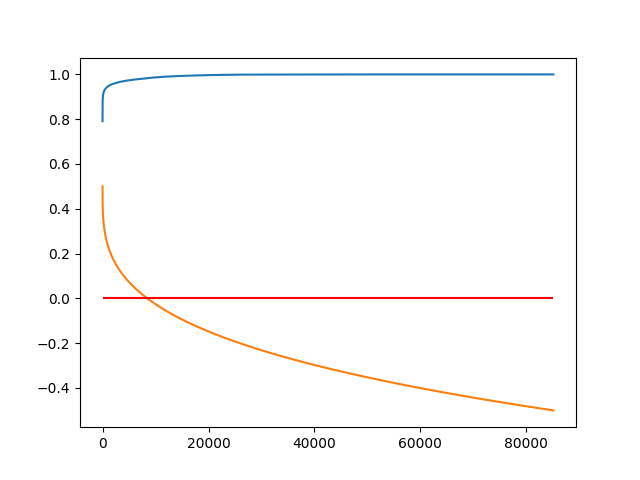

value1 85111
value2 8444


In [477]:

value2 = 0.5-linear_data
value1 = data_sorted
plt.figure()
plt.plot(value1)
plt.plot(value2)
plt.hlines(0,0,85111,colors='red')
plt.show()
print('value1', len(np.where(np.sign(value1)>0)[0]))
print('value2', len(np.where(np.sign(value2)>0)[0]))

In [310]:
data_sorted

array([0.01038357, 0.01430987, 0.01719139, ..., 0.6590493 , 0.66637444,
       0.66743755], dtype=float32)

In [277]:
uncertainties.min()

0.018277290872640607

In [54]:
def moving_average(data, window_size):
    """
    Apply a simple moving average filter to a time series data.

    Parameters:
    - data: array-like, the time series data.
    - window_size: int, the number of observations to consider for calculating the moving average.

    Returns:
    - smoothed_data: array-like, the smoothed time series.
    """
    weights = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, weights, mode='same')
    return smoothed_data

In [478]:
# uncertainties_metric = value1[original_order]
uncertainties_metric = value2[original_order]
metrics = strategy.dataset.combine_window_to_episode(uncertainties_metric, seq_len)
to_select = strategy.get_combined_important(torch.flatten(seq_len), metrics, 1700)
print('selected', np.sum(to_select))

total_select_from 6452.0
selected 1711.0


In [279]:
value1

array([ 0.08961643,  0.08569013,  0.08280861, ..., -0.55904925,
       -0.5663744 , -0.5674375 ], dtype=float32)

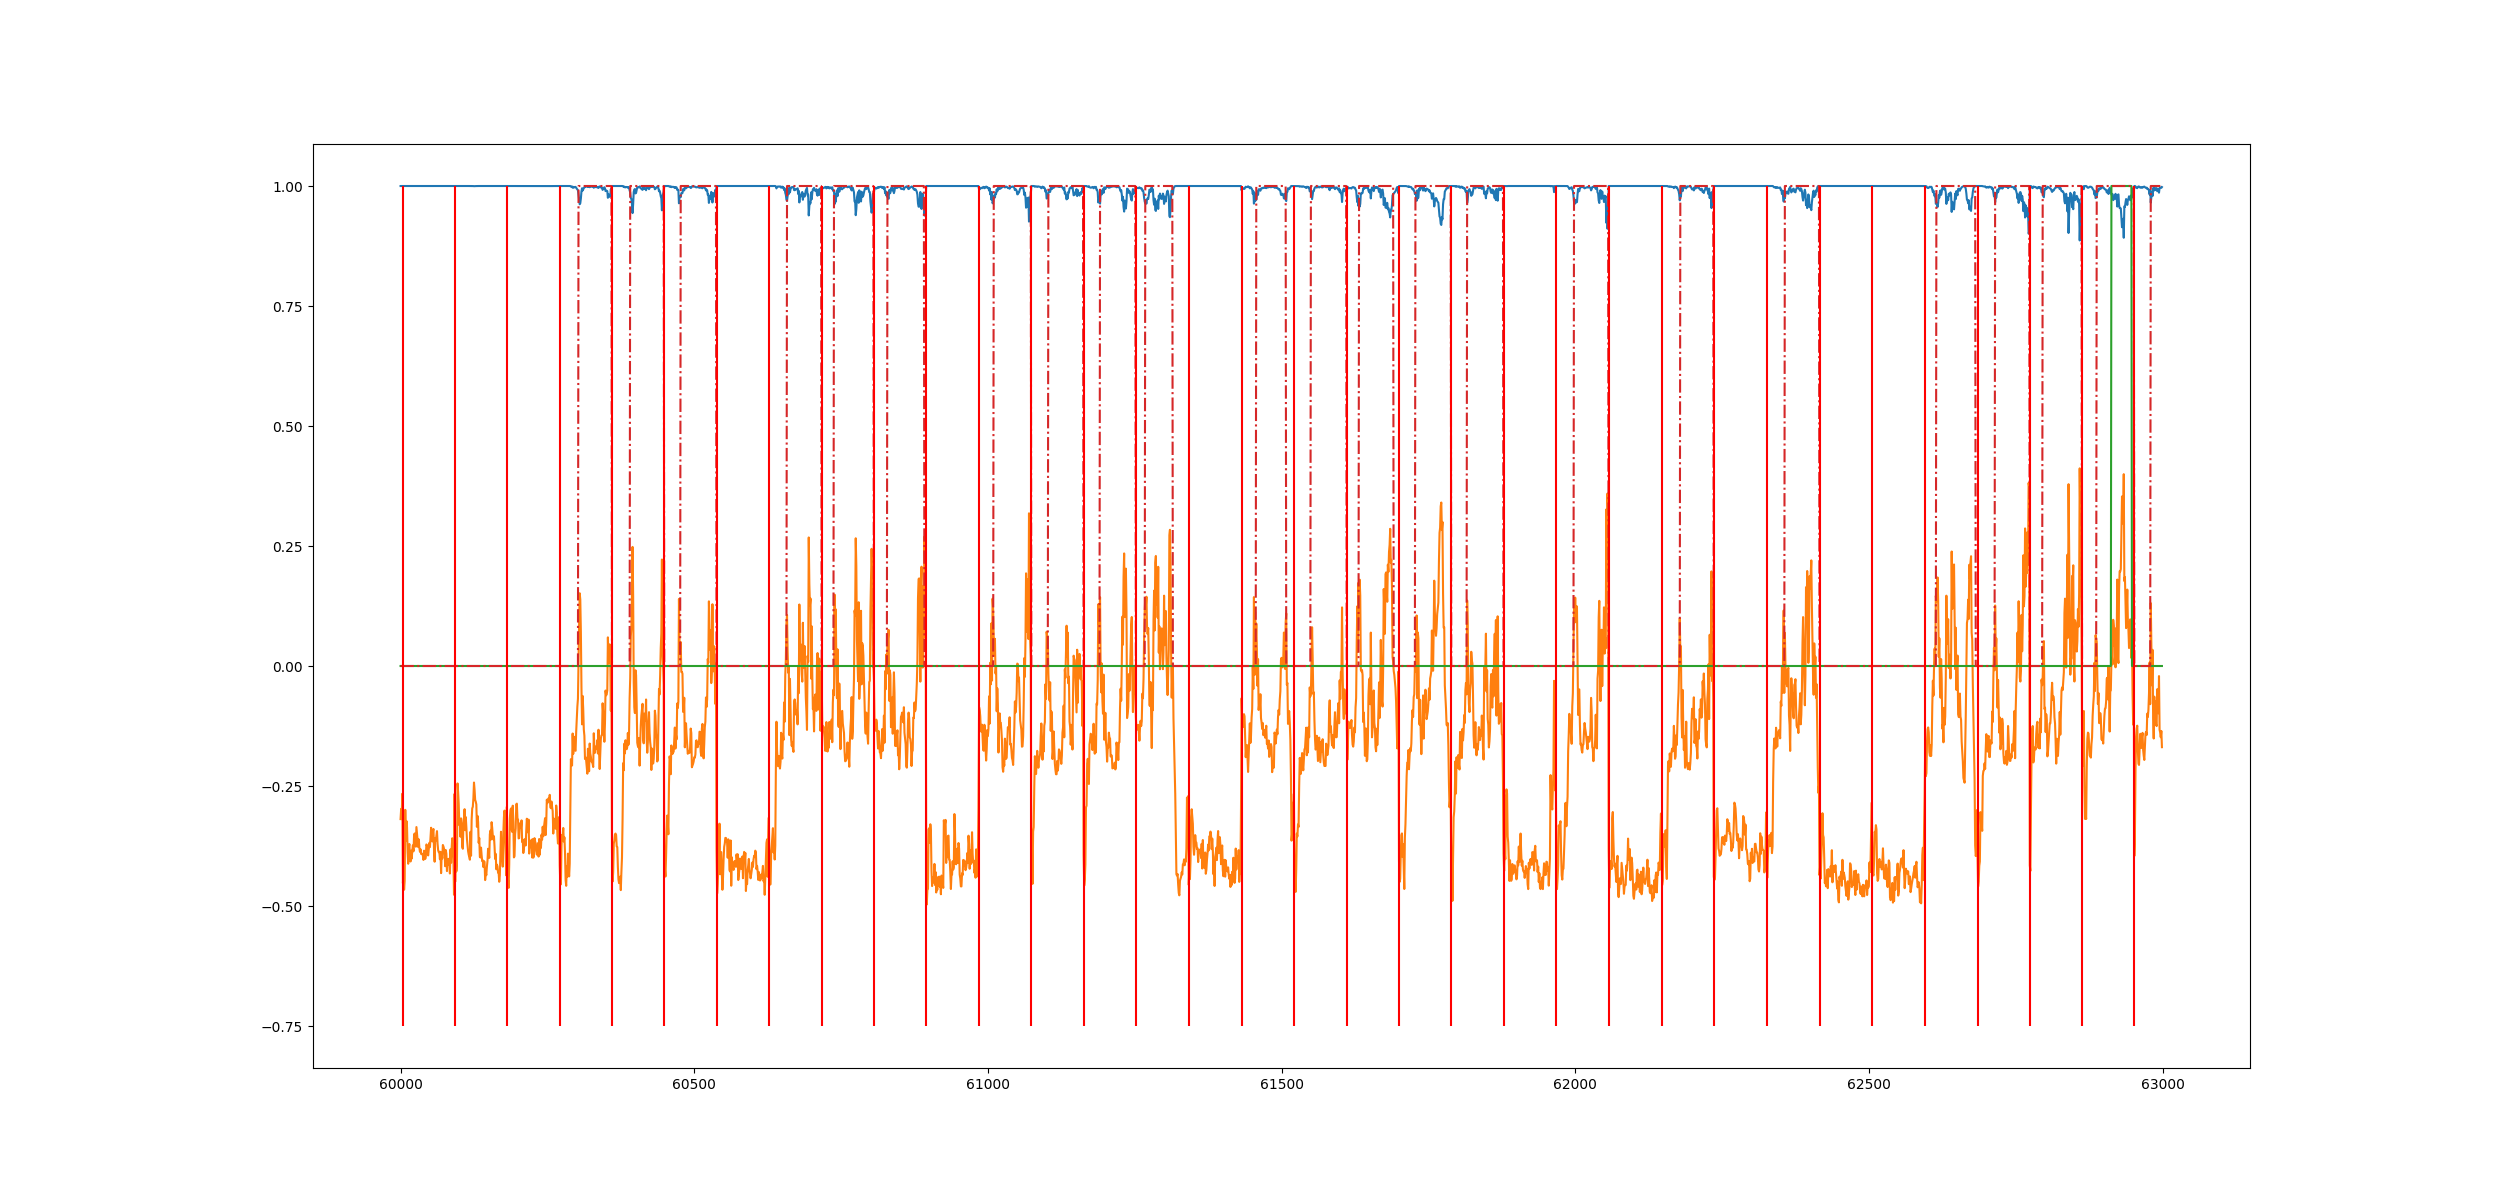

In [480]:
to_plot1 = 60000
to_plot2 = 63000
import matplotlib.pyplot as plt
x = np.arange(to_plot1,to_plot2)
plt.figure(figsize=(25,12))
plt.plot(x,uncertainties[to_plot1:to_plot2])
plt.plot(x,value2[original_order][to_plot1:to_plot2])
plt.plot(x,to_select[to_plot1:to_plot2])
plt.plot(x,np.concatenate(unlabeled_data.label)[to_plot1:to_plot2], '-.')
# plt.plot(x,output[to_plot1:to_plot2], '-.')

# plt.plot(x,probs.argmax(1)[to_plot1:to_plot2], '--', color = 'k')
# plt.hlines(0,to_plot1,to_plot2,colors='red')
plt.vlines(np.cumsum(seq_len)[np.where((np.cumsum(seq_len)>to_plot1)&(np.cumsum(seq_len)<to_plot2))[0]],-0.75,1, colors='red')
plt.show()

In [332]:
np.diff(output)-1

array([  0, 177,   0, ...,  90,   0,   1])

In [92]:
pb.shape

torch.Size([85111, 2])

In [73]:
import sklearn
clf_report = sklearn.metrics.classification_report(probs.argmax(1), np.concatenate(unlabeled_data.label), digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.986685  0.826295  0.899395     75421
           1   0.403144  0.913209  0.559355      9690

    accuracy                       0.836190     85111
   macro avg   0.694914  0.869752  0.729375     85111
weighted avg   0.920248  0.836190  0.860681     85111



In [58]:
unlabeled_data.label

array([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
              1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.])                                               ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
              1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0.])                                               ,
       array([

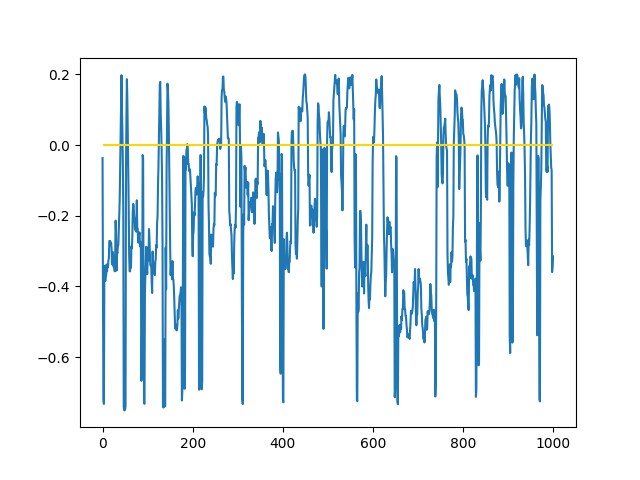

In [149]:
plt.figure()
plt.plot(0.2-linear_data[original_order][:to_plot])
plt.hlines(0,0,to_plot,colors='gold')
plt.show()

tensor([ 90, 180, 218, 308, 398, 488, 562, 652, 742, 832, 907, 967])

In [117]:
len(uncertainties)

85111

In [105]:

linear_data2, seq_len2 = strategy.dataset.get_slice_from_episode(linear_data[data_sorted_argsort], seq_len, ~unlabeled_idxs)
linear_data3 = np.concatenate(linear_data2)

85111
tensor(85111)
84332
tensor(85111)


AssertionError: 

In [107]:
threshold = 0.90

linear_data4 = strategy.dataset.combine_window_to_episode(threshold - linear_data3, seq_len2)
to_select = strategy.get_combined_important(torch.flatten(seq_len2), linear_data4, n)

unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
print('selected', np.sum(to_select), threshold)

84332
tensor(84332)
total_select_from 82791.0
85111
85111
85111
85111
selected 1777.0 0.9


In [109]:
np.argsort(threshold - linear_data3)

array([19576, 53686, 76852, ..., 77462, 53450, 19792], dtype=int64)

85111
tensor(85111)
85111
tensor(85111)


In [56]:
uncertainties = probs.max(1)[0]
uncertainties, seq_len = strategy.dataset.get_slice_from_episode(uncertainties, seq_len, ~unlabeled_idxs)

85111
tensor(84332)


AssertionError: 

In [52]:
log_probs = torch.log(probs)
uncertainties = (probs * log_probs).sum(1)

In [53]:
len(uncertainties)

85111

In [55]:
cum_sum_index = np.cumsum(seq_len)
cum_sum_index = np.insert(cum_sum_index, 0, 0)


print(len(uncertainties))
print(cum_sum_index[-1])

85111
tensor(84332)


In [36]:
uncertainties.sort()[0][:100]

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6930, -0.6930,
        -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930,
        -0.6930, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929,
        -0.6929, -0.6929, -0.6929, -0.6928, -0.6928, -0.6928, -0.6928, -0.6928,
        -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927,
        -0.6927, -0.6927, -0.6927, -0.6927, -0.6926, -0.6926, -0.6926, -0.6926,
        -0.6926, -0.6926, -0.6925, -0.6925, -0.6924, -0.6924, -0.6924, -0.6924,
        -0.6923, -0.6923, -0.6923, -0.6923, -0.6922, -0.6922, -0.6922, -0.6922,
        -0.6922, -0.6922, -0.6922, -0.6921, -0.6921, -0.6920, -0.6919, -0.6919,
        -0.6919, -0.6918, -0.6918, -0.69

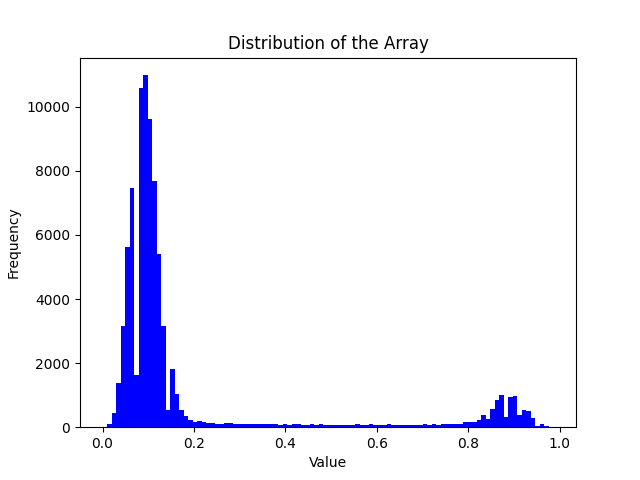

In [192]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(moving_average(pb[:,1],8), bins=100, color='blue')
plt.title('Distribution of the Array')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

array([0.04571762, 0.0457234 , 0.04575713, ..., 0.04572044, 0.04571527,
       0.04571011])

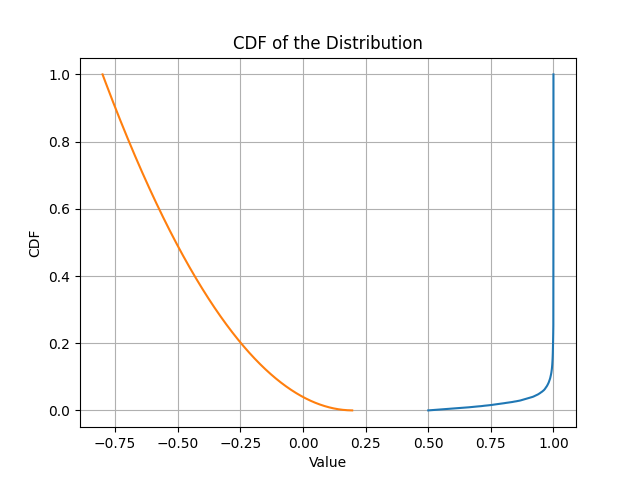

In [69]:


# Plotting the CDF
plt.figure()
plt.plot(data_sorted, cdf)
plt.plot(0.2-linear_data,cdf)
plt.title('CDF of the Distribution')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

In [38]:
np.vstack((data_sorted,cdf,linear_data))

array([[-6.93147182e-01, -6.93147063e-01, -6.93146408e-01, ...,
        -7.24521873e-04, -7.06738792e-04, -6.49171066e-04],
       [ 1.17493626e-05,  2.34987252e-05,  3.52480878e-05, ...,
         9.99976501e-01,  9.99988251e-01,  1.00000000e+00],
       [ 1.00000000e+00,  9.99988250e-01,  9.99976501e-01, ...,
         2.34990013e-05,  1.17495006e-05,  0.00000000e+00]])

In [50]:
n= 1700
linear_data, seq_len = strategy.dataset.get_slice_from_episode(uncertainties, seq_len, ~unlabeled_idxs)
# linear_data = np.concatenate(linear_data)
#
# threshold = 0.97
#
# metrics = strategy.dataset.combine_window_to_episode(threshold - uncertainties, seq_len)
# to_select = strategy.get_combined_important(torch.flatten(seq_len), metrics, n)
#
# unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
# print('selected', np.sum(to_select), threshold)

85111
tensor(84332)


AssertionError: 

In [58]:
len(linear_data)

84332

In [42]:
np.cumsum(seq_len)

tensor([   90,   180,   218,   308,   398,   488,   562,   652,   742,   832,
          907,   967,  1057,  1147,  1237,  1327,  1417,  1507,  1597,  1687,
         1777,  1867,  1957,  2047,  2137,  2227,  2317,  2407,  2497,  2587,
         2677,  2767,  2857,  2947,  3037,  3127,  3217,  3307,  3397,  3487,
         3577,  3667,  3757,  3814,  3904,  3994,  4084,  4174,  4264,  4354,
         4444,  4534,  4624,  4714,  4804,  4894,  4984,  5074,  5164,  5254,
         5344,  5434,  5524,  5614,  5704,  5794,  5884,  5974,  6064,  6154,
         6244,  6334,  6424,  6514,  6604,  6694,  6784,  6874,  6964,  7054,
         7144,  7234,  7324,  7414,  7504,  7594,  7624,  7714,  7804,  7894,
         7984,  8074,  8164,  8254,  8344,  8434,  8524,  8614,  8687,  8777,
         8867,  8957,  9047,  9137,  9227,  9317,  9407,  9497,  9587,  9677,
         9767,  9857,  9947, 10037, 10127, 10217, 10307, 10397, 10487, 10577,
        10667, 10757, 10847, 10937, 11027, 11116, 11206, 11296, 

Text(0.5, 1.0, 'Linear Transformation with Slope of 1')

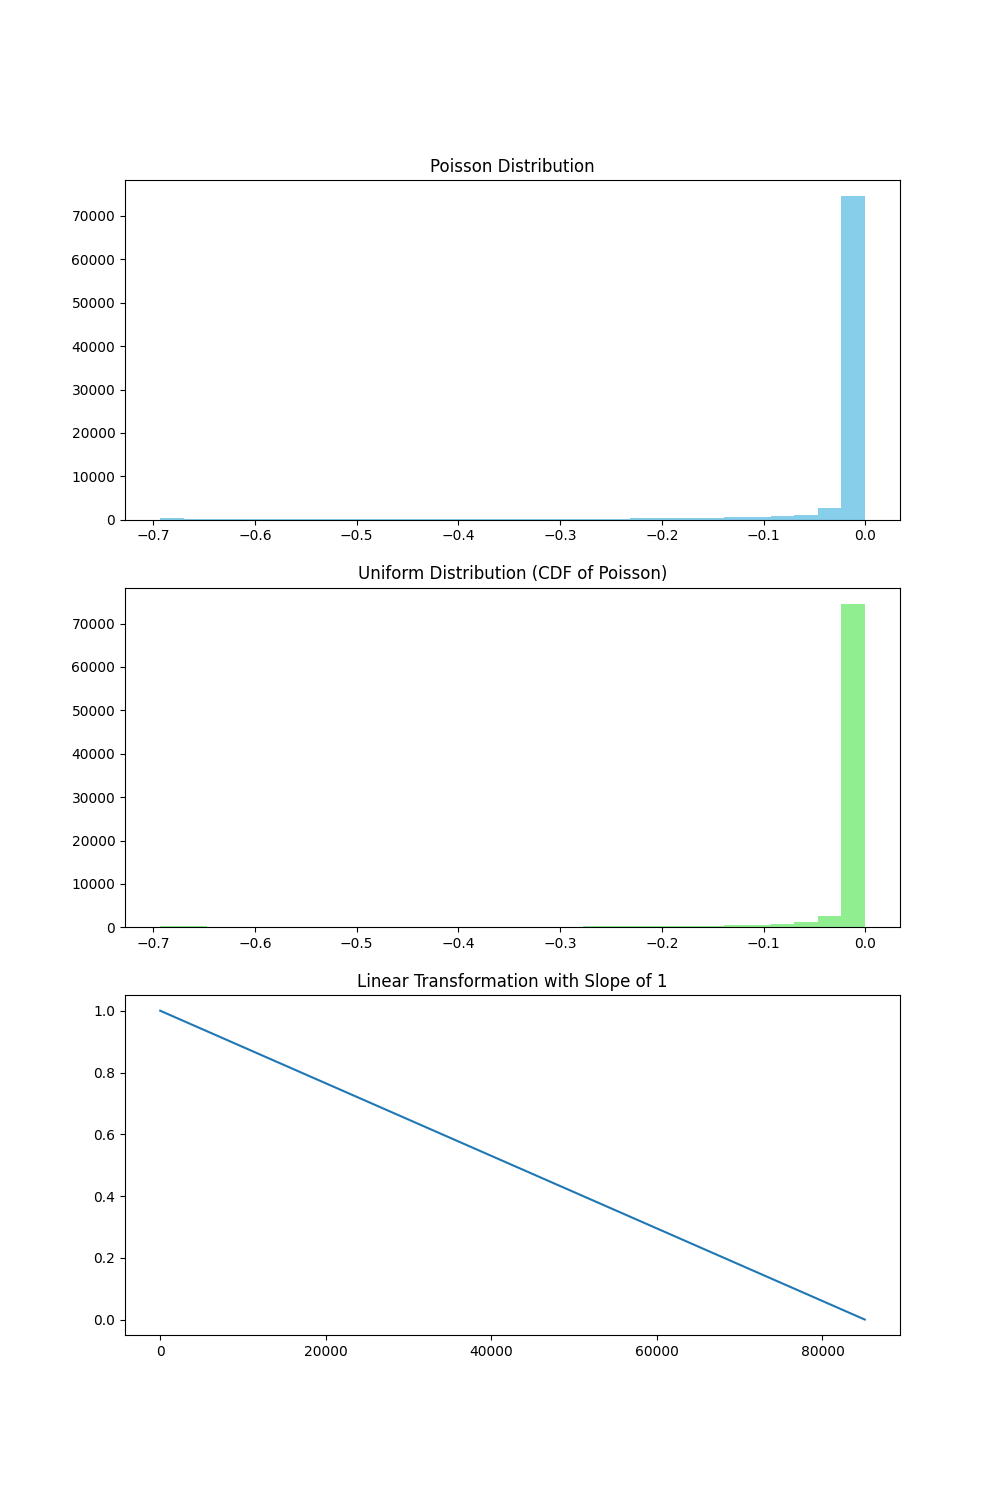

In [37]:


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].hist(uncertainties, bins=30, color='skyblue')
axs[0].set_title("Poisson Distribution")

axs[1].hist(uncertainties, bins=30, color='lightgreen')
axs[1].set_title("Uniform Distribution (CDF of Poisson)")

axs[2].plot(linear_data)
axs[2].set_title("Linear Transformation with Slope of 1")

In [ ]:

for rd in range(1, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd - 1) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd - 1) + '-epoch=' + str(int(max_row['epoch'])).zfill(2)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    q_idxs = strategy.query(NUM_QUERY * 90)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    selected_inds[rd] = q_idxs
    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
        pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    strategy.net.round = rd
    strategy.net.net.load_state_dict(modelstate)
    strategy.train()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


round 1
1


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

total_select_from 83349.0
selected 1780.0 0.97


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]